<a href="https://colab.research.google.com/github/batu-el/l65_be301_dc755/blob/main/Graph_Transformer_Cora_Attentions2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Installing PyTorch Geometric")
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-geometric
    print("Installing other libraries")
    !pip install networkx
    !pip install lovely-tensors

Installing PyTorch Geometric


Installing other libraries


In [2]:
import os
import sys
import time
import math
import random
import itertools
from datetime import datetime
from typing import Mapping, Tuple, Sequence, List

import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ReLU, BatchNorm1d, LayerNorm, Module, ModuleList, Sequential
from torch.nn import TransformerEncoder, TransformerEncoderLayer, MultiheadAttention
from torch.optim import Adam

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid

import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, dense_to_sparse, to_dense_batch, to_dense_adj

from torch_geometric.nn import GCNConv, GATConv

from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

import lovely_tensors as lt
lt.monkey_patch()

import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

/tmp/ipykernel_2844308/388978770.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


All imports succeeded.
Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.1.0+cu121
PyG version 2.4.0


In [3]:
# Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [4]:
# Download and load Cora dataset
dataset = 'Cora'
# transform = T.Compose([T.NormalizeFeatures(), T.GCNNorm(), T.ToSparseTensor()])
dataset = Planetoid('/tmp/Cora', dataset)
data = dataset[0]

## Adjacency Matrix Heatmap

<ipython-input-5-449309cf93f5>:9: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt) # degree-normalised adjacency


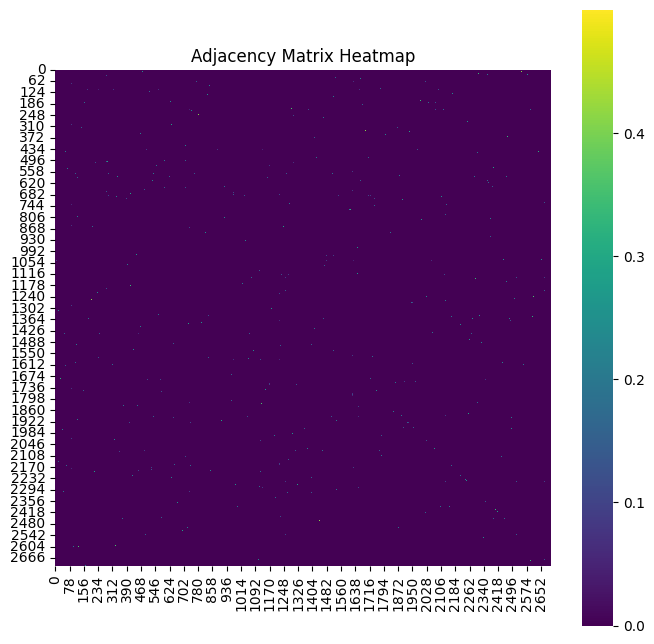

In [ ]:
# adjacency matrices for Cora
A = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
A_tilde = A + torch.eye(A.shape[0])
D_tilde = torch.diag(torch.sum(A_tilde, axis=1))
D_tilde_inv_sqrt = torch.pow(D_tilde, -0.5)
D_tilde_inv_sqrt[torch.isinf(D_tilde_inv_sqrt)] = 0.0
A_tilde = A_tilde.to_sparse()
D_tilde_inv_sqrt = D_tilde_inv_sqrt.to_sparse()
adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt) # degree-normalised adjacency
L = torch.eye(adj_norm.shape[0]) - adj_norm  # graph laplacian

# # Eigenvectors with numpy
# EigVal, EigVec = np.linalg.eig(L)
# idx = EigVal.argsort() # sort in increasing order
# EigVal, EigVec = EigVal[idx], np.real(EigVec[:,idx])

plt.figure(figsize=(8, 8))
sns.heatmap(adj_norm.to_dense().numpy(), cmap='viridis', square=True)
plt.title('Adjacency Matrix Heatmap')
plt.show()

In [ ]:
# PyG example code: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gcn2_cora.py

class GNNModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            hidden_dim: int = 128,
            num_heads: int = 1,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # GCNConv(hidden_dim, hidden_dim)
                GATConv(hidden_dim, hidden_dim // num_heads, num_heads)
            )
        self.dropout = dropout

    def forward(self, x, edge_index):

        x = self.lin_in(x)

        for layer in self.layers:
            # conv -> activation ->  dropout -> residual
            x_in = x
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNNModel().to(device)

data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.edge_index).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 0001, Loss: 1.9564 Train: 0.4143, Val: 0.1540, Test: 0.1650, Final Test: 0.1650
Epoch: 0002, Loss: 1.8827 Train: 0.7071, Val: 0.2200, Test: 0.2460, Final Test: 0.2460
Epoch: 0003, Loss: 1.8154 Train: 0.8929, Val: 0.2880, Test: 0.3280, Final Test: 0.3280
Epoch: 0004, Loss: 1.7430 Train: 0.9214, Val: 0.3480, Test: 0.4090, Final Test: 0.4090
Epoch: 0005, Loss: 1.6689 Train: 0.9571, Val: 0.4020, Test: 0.4590, Final Test: 0.4590
Epoch: 0006, Loss: 1.5866 Train: 0.9857, Val: 0.4600, Test: 0.4970, Final Test: 0.4970
Epoch: 0007, Loss: 1.5064 Train: 0.9929, Val: 0.4960, Test: 0.5360, Final Test: 0.5360
Epoch: 0008, Loss: 1.4049 Train: 0.9929, Val: 0.5420, Test: 0.5630, Final Test: 0.5630
Epoch: 0009, Loss: 1.3038 Train: 0.9929, Val: 0.5700, Test: 0.5910, Final Test: 0.5910
Epoch: 0010, Loss: 1.2217 Train: 0.9929, Val: 0.6120, Test: 0.6130, Final Test: 0.6130
Epoch: 0011, Loss: 1.0937 Train: 0.9929, Val: 0.6320, Test: 0.6360, Final Test: 0.6360
Epoch: 0012, Loss: 0.9883 Train: 0.9929, Va

In [ ]:
ATTENTION_LIST = []
class SparseGraphTransformerModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            hidden_dim: int = 128,
            num_heads: int = 1,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # TransformerEncoderLayer(
                #     d_model = hidden_dim,
                #     nhead = num_heads,
                #     dim_feedforward = hidden_dim * 2,
                #     dropout = dropout,
                # )
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )
        # self.encoder = TransformerEncoder(
        #     TransformerEncoderLayer(
        #         d_model = hidden_dim,
        #         nhead = num_heads,
        #         dim_feedforward = hidden_dim * 2,
        #         dropout = dropout,
        #     ),
        #     num_layers
        # )

        self.dropout = dropout

    def forward(self, x, dense_adj):

        x = self.lin_in(x)

        # TransformerEncoder
        # x = self.encoder(x, mask = ~dense_adj.bool())


        for layer in self.layers:
            # # TransformerEncoderLayer
            # # boolean mask enforces graph structure
            # x = layer(x, src_mask = ~dense_adj.bool())

            # MHSA layer
            # boolean mask enforces graph structure
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = ~dense_adj.bool(),
                average_attn_weights = False
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x
            if epoch == 99:
              ATTENTION_LIST.append(attn_weights)
        x = self.lin_out(x)
        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SparseGraphTransformerModel().to(device)

data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.dense_adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.dense_adj).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 0001, Loss: 1.9482 Train: 0.4071, Val: 0.1320, Test: 0.1090, Final Test: 0.1090
Epoch: 0002, Loss: 1.8864 Train: 0.6714, Val: 0.1700, Test: 0.1580, Final Test: 0.1580
Epoch: 0003, Loss: 1.8289 Train: 0.8643, Val: 0.2260, Test: 0.2330, Final Test: 0.2330
Epoch: 0004, Loss: 1.7733 Train: 0.9357, Val: 0.3040, Test: 0.3190, Final Test: 0.3190
Epoch: 0005, Loss: 1.7093 Train: 0.9714, Val: 0.3820, Test: 0.4010, Final Test: 0.4010
Epoch: 0006, Loss: 1.6439 Train: 1.0000, Val: 0.4500, Test: 0.4690, Final Test: 0.4690
Epoch: 0007, Loss: 1.5768 Train: 1.0000, Val: 0.5320, Test: 0.5270, Final Test: 0.5270
Epoch: 0008, Loss: 1.5027 Train: 1.0000, Val: 0.5800, Test: 0.5870, Final Test: 0.5870
Epoch: 0009, Loss: 1.4280 Train: 1.0000, Val: 0.6400, Test: 0.6250, Final Test: 0.6250
Epoch: 0010, Loss: 1.3305 Train: 1.0000, Val: 0.6660, Test: 0.6530, Final Test: 0.6530
Epoch: 0011, Loss: 1.2390 Train: 1.0000, Val: 0.6800, Test: 0.6820, Final Test: 0.6820
Epoch: 0012, Loss: 1.1276 Train: 1.0000, Va

In [ ]:
ATTENTION_LIST[0].detach().cpu().numpy().squeeze()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.4561233],
       [0.       , 0.       , 0.       , ..., 0.       , 0.5090879,
        0.       ]], dtype=float32)

In [ ]:
ATTENTION_LIST[1].detach().cpu().numpy().squeeze()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.4852744],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
ATTENTION_LIST[2].detach().cpu().numpy().squeeze()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.86174107, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.47448996],
       [0.        , 0.        , 0.        , ..., 0.        , 0.4703186 ,
        0.        ]], dtype=float32)

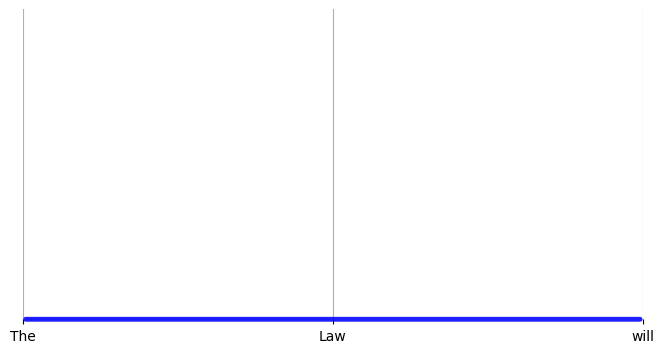

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Mock data: attention_weights for visualization
# Replace this with your actual attention weights
attention_weights = np.array([
    [0.1, 0.2, 0.7],
    [0.8, 0.1, 0.1],
    [0.3, 0.3, 0.4]
])

# Token labels for the sequence
tokens = ['The', 'Law', 'will']

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Maximum weight for normalizing line thickness
max_weight = np.max(attention_weights)

# Plot the lines
for i, token1 in enumerate(tokens):
    for j, token2 in enumerate(tokens):
        # Only draw the upper half of the matrix
        if i < j:
            weight = attention_weights[i][j]
            alpha = weight / max_weight  # Normalizing the alpha by weight for visibility
            ax.annotate("", xy=(j, 0), xytext=(i, 0),
                        arrowprops=dict(arrowstyle="-", color='blue', alpha=alpha, lw=weight*5))

# Set the tokens as the x-axis labels
ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens)

# Remove y-axis and spines
ax.yaxis.set_visible(False)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

# Set the aspect of the plot to be equal
ax.set_aspect('equal')

# Add grid and show plot
ax.grid(True)
plt.show()


In [ ]:
ATTENTION_MATRIX_0 = ATTENTION_LIST[0].detach().cpu().numpy().squeeze()
ADJACENCY = data.dense_adj.cpu().numpy()
ATTENTION_MATRIX.shape, ADJACENCY.shape

((2708, 2708), (2708, 2708))

In [ ]:
treshold = 0
ATTENTION_MATRIX[ ATTENTION_MATRIX > treshold] = 1
ATTENTION_MATRIX[ ATTENTION_MATRIX <= treshold] = 0
ATTENTION_MATRIX.sum()

5350.0

In [ ]:
A = ATTENTION_MATRIX
A_cubed = np.linalg.matrix_power(A, 3)
A_cubed, np.trace(A_cubed)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 1., 2.],
        [0., 0., 0., ..., 0., 2., 1.]], dtype=float32),
 1095.0)

In [ ]:
A = ADJACENCY
A_cubed = np.linalg.matrix_power(A, 3)
A_cubed, np.trace(A_cubed)

(array([[ 2.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  7., ...,  0.,  0.,  0.],
        [ 0.,  7.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  6., 11.],
        [ 0.,  0.,  0., ...,  0., 11., 10.]], dtype=float32),
 9780.0)

## Commute Times via the Laplacian

In [ ]:
import numpy as np
from scipy.linalg import pinv

def compute_commute_times(A):
    n = A.shape[0]  # Number of vertices
    D = np.diag(A.sum(axis=1))  # Degree matrix
    L = D - A  # Laplacian matrix
    L_pinv = pinv(L)  # Pseudoinverse of the Laplacian
    V = np.sum(A) / 2  # Total number of edges, for undirected graph

    commute_times = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            commute_times[i, j] = V * (L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j])

    return commute_times

In [ ]:
ADJACENCY_commute_time = compute_commute_times(ADJACENCY)
ATTENTION_MATRIX_commute_time = compute_commute_times(ATTENTION_MATRIX)

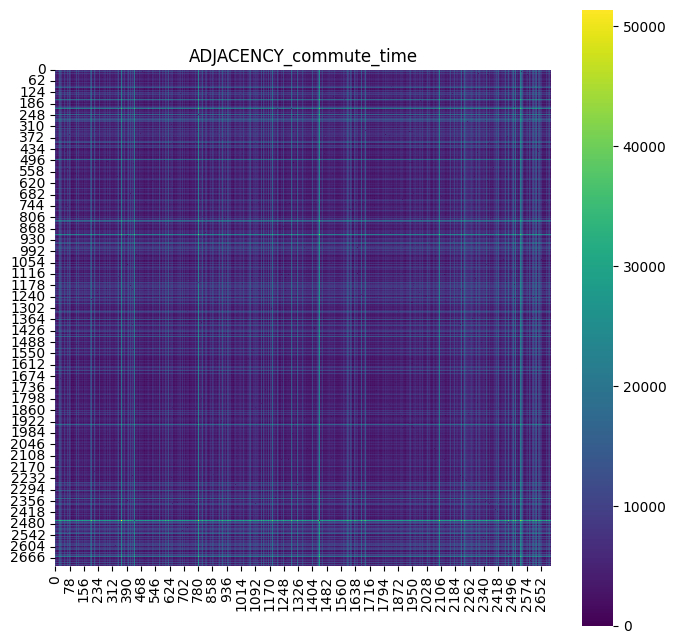

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(ADJACENCY_commute_time, cmap='viridis', square=True)
plt.title('ADJACENCY_commute_time')
plt.show()

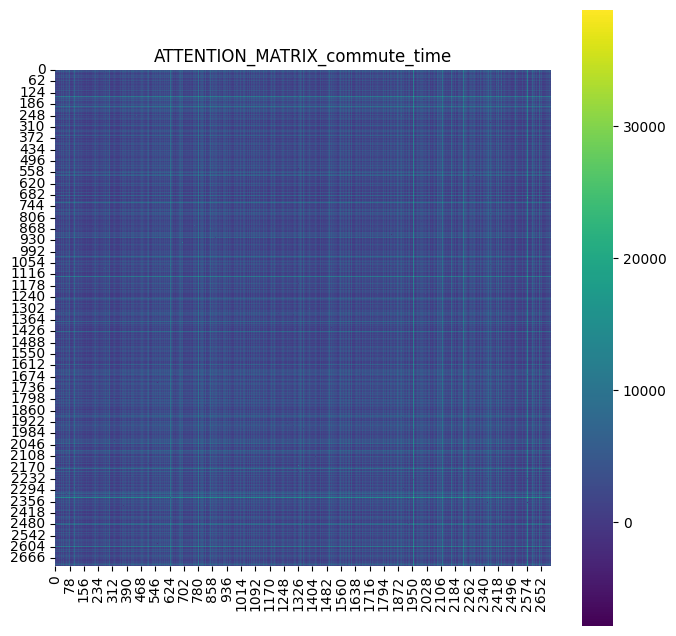

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(ATTENTION_MATRIX_commute_time, cmap='viridis', square=True)
plt.title('ATTENTION_MATRIX_commute_time')
plt.show()

In [ ]:
ATTENTION_MATRIX_commute_time[ATTENTION_MATRIX_commute_time < 0]

array([-1.45889033e-04, -1.97362253e-03, -2.85963096e-03, ...,
       -3.86065811e-13, -2.04011874e-12, -2.62059569e+00])

In [ ]:
print('adj', compute_commute_times(ADJACENCY))
print('att', compute_commute_times(ATTENTION_MATRIX))

adj [[   0.         8476.7509922  5714.99195437 ... 5099.36117582
  6792.07049935 6262.99336059]
 [8476.72052335    0.         3909.11105168 ... 6041.23098414
  7815.76195414 7292.67206688]
 [5714.99330613 3909.21266532    0.         ... 3304.75686786
  5045.09875805 4524.2658468 ]
 ...
 [5099.36075672 6041.22426816 3304.75385103 ...    0.
  4449.50022142 3922.71160198]
 [6792.06865111 7815.76569731 5045.0990284  ... 4449.49985449
     0.         2306.90145445]
 [6262.99204323 7292.67597472 4524.26735095 ... 3922.71131775
  2306.89956689    0.        ]]
att [[   0.         1752.98741761 2613.51170714 ...  668.74998664
  1670.09172554 4647.8372629 ]
 [1756.34429442    0.          901.43038929 ... 2425.08294789
  3471.7725436  6496.8027045 ]
 [2620.39757074 4434.27113295    0.         ... 3289.1339687
  4351.44622927 7392.14368863]
 ...
 [ 668.75005651 2425.08285902 3289.13375421 ...    0.
  2342.72736943 5324.45401686]
 [1673.98399382 3465.54685005 4361.63918916 ... 2342.72772452
     0

## Random Walk Statistics

In [ ]:
import numpy as np

# Sample adjacency matrix
A = ATTENTION_MATRIX
# Convert to transition matrix P
row_sums = A.sum(axis=1, keepdims=True)
P = A / row_sums
P = np.nan_to_num(P)
# Calculate stationary distribution
# We solve (pi*P = pi) by finding the eigenvector of P.T corresponding to eigenvalue 1
eigenvalues, eigenvectors = np.linalg.eig(P.T)
pi_index = np.argmin(np.abs(eigenvalues - 1)) # Find index of eigenvalue closest to 1
stationary_distribution = np.real(eigenvectors[:, pi_index] / np.sum(eigenvectors[:, pi_index]))
stationary_distribution_attention = stationary_distribution

# Sample adjacency matrix
A = ADJACENCY
row_sums = A.sum(axis=1, keepdims=True)
P = A / row_sums
P = np.nan_to_num(P)
eigenvalues, eigenvectors = np.linalg.eig(P.T)
pi_index = np.argmin(np.abs(eigenvalues - 1)) # Find index of eigenvalue closest to 1
stationary_distribution = np.real(eigenvectors[:, pi_index] / np.sum(eigenvectors[:, pi_index]))
stationary_distribution_adjacency = stationary_distribution

<ipython-input-46-19f77b1cb134>:7: RuntimeWarning: invalid value encountered in divide
  P = A / row_sums


In [ ]:
np.argwhere(stationary_distribution_attention == stationary_distribution_attention.max())

array([[1436],
       [2259]])

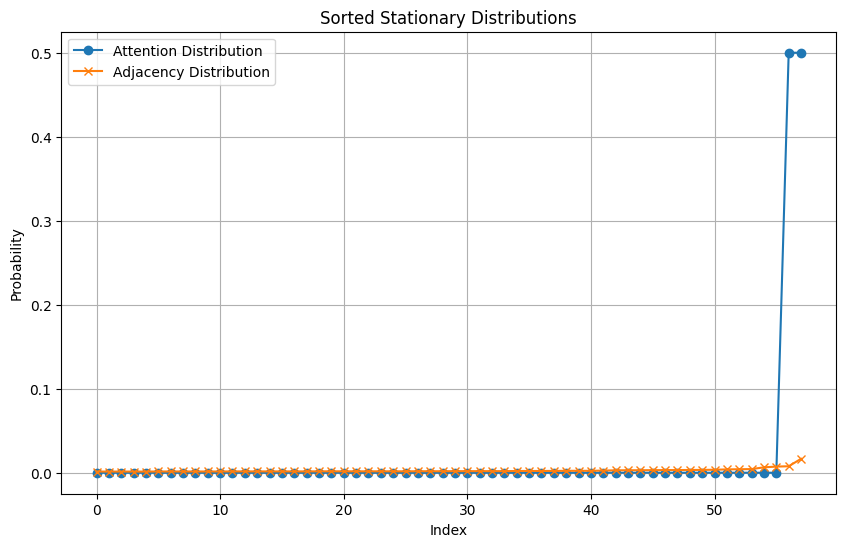

In [ ]:
cutoff = 2650
y1 = np.sort(stationary_distribution_attention)[cutoff:]
y2 = np.sort(stationary_distribution_adjacency)[cutoff:]
x = np.array(range(len(y1)))
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y1, label='Attention Distribution', marker='o')
plt.plot(x, y2, label='Adjacency Distribution', marker='x')
plt.title('Sorted Stationary Distributions')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
stationary_distribution_attention.mean(), stationary_distribution_attention.std(), stationary_distribution_attention.min(), stationary_distribution_attention.max()

(0.0003692762, 0.01358314, 0.0, 0.49999997)

In [ ]:
stationary_distribution_adjacency.mean(), stationary_distribution_adjacency.std(), stationary_distribution_adjacency.min(), stationary_distribution_adjacency.max()

(0.0003692762, 0.0005225877, -4.880632e-11, 0.016571317)

# Analysis of Shortest Paths

In [ ]:
def get_shortest_path_matrix(adjacency_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    graph = nx.from_numpy_array(adjacency_matrix, create_using=nx.DiGraph)
    # Compute the shortest path matrix using Floyd-Warshall algorithm in NetworkX
    shortest_path_matrix = nx.floyd_warshall_numpy(graph)
    # Convert numpy array back to torch tensor
    shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
    return shortest_path_matrix

In [ ]:
ATTENTION_SHORTEST_PATH = get_shortest_path_matrix(ATTENTION_MATRIX)
print('done')

done


In [ ]:
ADJACENCY_SHORTEST_PATH = get_shortest_path_matrix(ADJACENCY)
print('done')

In [ ]:
ATTENTION_SHORTEST_PATH[ATTENTION_SHORTEST_PATH != np.inf].max(), ADJACENCY_SHORTEST_PATH[ADJACENCY_SHORTEST_PATH != np.inf].max()

(tensor 26.000, tensor 19.000)

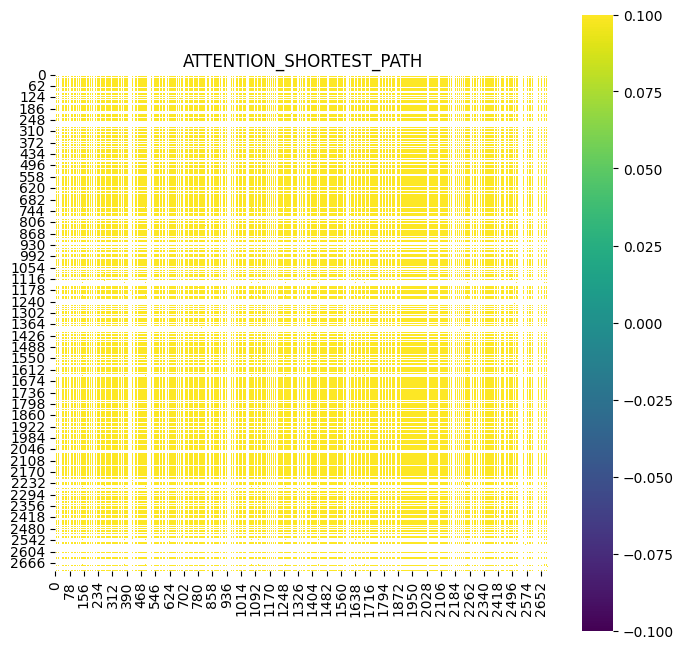

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(ATTENTION_SHORTEST_PATH.numpy(), cmap='viridis', square=True)
plt.title('ATTENTION_SHORTEST_PATH')
plt.show()

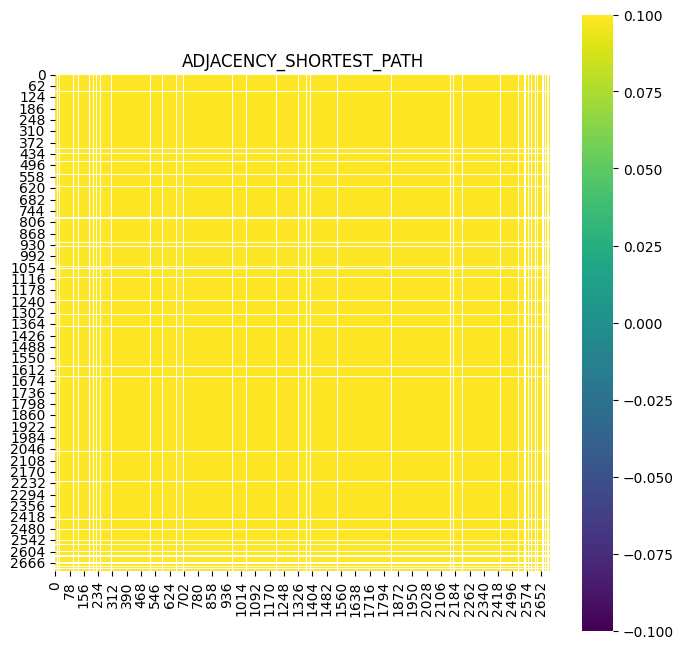

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(ADJACENCY_SHORTEST_PATH.numpy(), cmap='viridis', square=True)
plt.title('ADJACENCY_SHORTEST_PATH')
plt.show()

In [ ]:
ATTENTION_MATRIX.sum(axis=0), ATTENTION_MATRIX.sum(axis=1)

In [ ]:
(ADJACENCY.sum(axis=0) != ADJACENCY.sum(axis=1)).sum()

In [ ]:
# (ADJACENCY -ATTENTION_MATRIX).sum(axis=0).sum()
# plt.figure(figsize=(8, 8))
# sns.heatmap(ADJACENCY, cmap='viridis', square=True)
# plt.title('ADJACENCY')
# plt.show()

<ipython-input-24-560b91e693ff>:7: RuntimeWarning: invalid value encountered in divide
  P = A / row_sums


LinAlgError: Array must not contain infs or NaNs

## Thresholding and Degree Distribution

In [ ]:
threshold = 0.5
ATTENTION_MATRIX[ ATTENTION_MATRIX >= threshold] = 1
ATTENTION_MATRIX[ ATTENTION_MATRIX < threshold] = 0
ATTENTION_MATRIX.sum()

In [ ]:
pd.DataFrame(ATTENTION_MATRIX.sum(axis=1)).value_counts()

In [ ]:
pd.DataFrame(ATTENTION_MATRIX.sum(axis=1))[pd.DataFrame(ATTENTION_MATRIX.sum(axis=1)) == 98.0].dropna()

In [ ]:
ATTENTION_MATRIX[2259][1436], ATTENTION_MATRIX[1436][2259]

(1.0, 1.0)

In [ ]:
ADJACENCY[1358].sum()

In [ ]:
pd.DataFrame(ADJACENCY.sum(axis=0)).value_counts()

In [ ]:
def get_shortest_path_matrix(adjacency_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    graph = nx.from_numpy_array(adjacency_matrix.cpu().numpy(), create_using=nx.DiGraph)
    # Compute the shortest path matrix using Floyd-Warshall algorithm in NetworkX
    shortest_path_matrix = nx.floyd_warshall_numpy(graph)
    # Convert numpy array back to torch tensor
    shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
    return shortest_path_matrix

In [ ]:
pd.DataFrame(ATTENTION_MATRIX.sum(axis=0)).hist()

In [ ]:
ADJACENCY.sum(axis=0)

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(ATTENTION_MATRIX, cmap='viridis', square=True)
plt.title('ATTENTION_MATRIX')
plt.show()

In [ ]:
num_layers = len(model.attn_weights_list)
num_heads = model.attn_weights_list[0].shape[0]

fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 4, num_layers * 4))

for layer_idx in range(num_layers):
    for head_idx in range(num_heads):
        ax = axes[layer_idx, head_idx]

        # Extract the attention heatmap for the current layer and head
        attn_heatmap = model.attn_weights_list[layer_idx][head_idx, :, :].cpu().numpy()

        # Plot the heatmap on the current subplot
        sns.heatmap(attn_heatmap, cmap='viridis', square=True, ax=ax)

        ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
        ax.axis('off')

plt.suptitle('Attention Heatmaps', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
def get_shortest_path_matrix(adjacency_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    graph = nx.from_numpy_array(adjacency_matrix.cpu().numpy(), create_using=nx.DiGraph)
    # Compute the shortest path matrix using Floyd-Warshall algorithm in NetworkX
    shortest_path_matrix = nx.floyd_warshall_numpy(graph)
    # Convert numpy array back to torch tensor
    shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
    return shortest_path_matrix

dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
dense_shortest_path_matrix = get_shortest_path_matrix(dense_adj)  # takes about 1-2 mins

In [ ]:
class DenseGraphTransformerModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            pos_enc_dim: int = 16,
            hidden_dim: int = 128,
            num_heads: int = 4,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_pos_enc = Linear(pos_enc_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # TransformerEncoderLayer(
                #     d_model = hidden_dim,
                #     nhead = num_heads,
                #     dim_feedforward = hidden_dim * 2,
                #     dropout = dropout,
                # )
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )
        # self.encoder = TransformerEncoder(
        #     TransformerEncoderLayer(
        #         d_model = hidden_dim,
        #         nhead = num_heads,
        #         dim_feedforward = hidden_dim * 2,
        #         dropout = dropout,
        #     ),
        #     num_layers
        # )

        self.attn_bias_scale = torch.nn.Parameter(torch.tensor([10.0]))  # controls how much we initially bias our model to nearby nodes
        self.dropout = dropout

    def forward(self, x, pos_enc, dense_sp_matrix):

        # x = self.lin_in(x) + self.lin_pos_enc(pos_enc)
        x = self.lin_in(x)  # no node positional encoding

        # attention bias
        # [i, j] -> inverse of shortest path distance b/w node i and j
        # diagonals -> self connection, set to 0
        # disconnected nodes -> -1
        attn_bias = self.attn_bias_scale * torch.nan_to_num(
            (1 / (torch.nan_to_num(dense_sp_matrix, nan=-1, posinf=-1, neginf=-1))),
            nan=0, posinf=0, neginf=0
        )

        # TransformerEncoder
        # x = self.encoder(x, mask = attn_bias)

        self.attn_weights_list = []

        for layer in self.layers:
            # # TransformerEncoderLayer
            # # float mask adds learnable additive attention bias
            # x = layer(x, src_mask = attn_bias)

            # MHSA layer
            # float mask adds learnable additive attention bias
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = attn_bias,
                average_attn_weights = False
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DenseGraphTransformerModel().to(device)

data = T.AddLaplacianEigenvectorPE(k = 16, attr_name = 'pos_enc')(data)
# data = T.AddRandomWalkPE(walk_length = 16, attr_name = 'pos_enc')(data)
data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
data.dense_sp_matrix = dense_shortest_path_matrix.float()  # pre-computed in previous cell
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.pos_enc, data.dense_sp_matrix)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.pos_enc, data.dense_sp_matrix).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

# Notes
# - Dense Transformer needs to be trained for a bit longer to reach low loss value
# - Node positional encodings are not particularly useful
# - Edge distance encodings are very useful
# - Since Cora is highly homophilic, it is important to bias the attention towards nearby nodes

In [ ]:
num_layers = len(model.attn_weights_list)
num_heads = model.attn_weights_list[0].shape[0]

fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 4, num_layers * 4))

for layer_idx in range(num_layers):
    for head_idx in range(num_heads):
        ax = axes[layer_idx, head_idx]

        # Extract the attention heatmap for the current layer and head
        attn_heatmap = model.attn_weights_list[layer_idx].cpu().numpy()[head_idx]

        # Plot the heatmap on the current subplot
        sns.heatmap(attn_heatmap, cmap='viridis', square=True, ax=ax)

        ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
        ax.axis('off')

plt.suptitle('Attention Heatmaps', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
class DenseGraphTransformerModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            pos_enc_dim: int = 16,
            hidden_dim: int = 128,
            num_heads: int = 4,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_pos_enc = Linear(pos_enc_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # TransformerEncoderLayer(
                #     d_model = hidden_dim,
                #     nhead = num_heads,
                #     dim_feedforward = hidden_dim * 2,
                #     dropout = dropout,
                # )
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )
        # self.encoder = TransformerEncoder(
        #     TransformerEncoderLayer(
        #         d_model = hidden_dim,
        #         nhead = num_heads,
        #         dim_feedforward = hidden_dim * 2,
        #         dropout = dropout,
        #     ),
        #     num_layers
        # )

        # controls how much we initially bias our model to nearby nodes
        self.attn_bias_scale = Linear(1, num_heads, bias=False)
        with torch.no_grad():
            self.attn_bias_scale.weight.data = torch.linspace(
                0, 10, steps=num_heads, requires_grad=True
            ).unsqueeze(-1)

        self.dropout = dropout

    def forward(self, x, pos_enc, dense_sp_matrix):

        # x = self.lin_in(x) + self.lin_pos_enc(pos_enc)
        x = self.lin_in(x)  # no node positional encoding

        # attention bias
        # [i, j] -> inverse of shortest path distance b/w node i and j
        # diagonals -> self connection, set to 0
        # disconnected nodes -> -1
        attn_bias = torch.nan_to_num(
            (1 / (torch.nan_to_num(dense_sp_matrix, nan=-1, posinf=-1, neginf=-1))),
            nan=0, posinf=0, neginf=0
        ).unsqueeze(-1)
        # learnable scaling factor
        attn_bias = self.attn_bias_scale(attn_bias).permute(2, 0, 1)

        # TransformerEncoder
        # x = self.encoder(x, mask = attn_bias)

        self.attn_weights_list = []

        for layer in self.layers:
            # # TransformerEncoderLayer
            # # float mask adds learnable additive attention bias
            # x = layer(x, src_mask = attn_bias)

            # MHSA layer
            # float mask adds learnable additive attention bias
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = attn_bias,
                average_attn_weights = False
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DenseGraphTransformerModel().to(device)

data = T.AddLaplacianEigenvectorPE(k = 16, attr_name = 'pos_enc')(data)
# data = T.AddRandomWalkPE(walk_length = 16, attr_name = 'pos_enc')(data)
data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
data.dense_sp_matrix = dense_shortest_path_matrix.float()  # pre-computed in previous cell
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.pos_enc, data.dense_sp_matrix)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.pos_enc, data.dense_sp_matrix).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

# Notes
# - Dense Transformer needs to be trained for a bit longer to reach low loss value
# - Node positional encodings are not particularly useful
# - Edge distance encodings are very useful
# - Since Cora is highly homophilic, it is important to bias the attention towards nearby nodes